라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 4
model_name = 'Test230725_tank4_lstm_crop720_only-feed'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 720, 1))
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 720, 1))

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 720, 1))
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 720, 1))

In [9]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1
nCar: 90 nVar: 720
nCar: 90 nVar: 1
nCar: 90 nVar: 720


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [10]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(720, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(720, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-25 00:06:16.218475: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 00:06:16.724480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 720, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 720)               23760     
Total params: 152,144
Trainable params: 152,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


2023-07-25 00:06:17.704264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-25 00:06:22.635865: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-25 00:06:23.840341: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 8s 764ms/step - loss: 78.8998 - mae: 8.6398 - r_squared: -18.7734 - val_loss: 78.8360 - val_mae: 8.6361 - val_r_squared: -21.7192
Epoch 2/1000
3/3 [==============================] - 1s 203ms/step - loss: 78.7719 - mae: 8.6325 - r_squared: -20.8236 - val_loss: 78.5410 - val_mae: 8.6189 - val_r_squared: -21.6343
Epoch 3/1000
3/3 [==============================] - 1s 219ms/step - loss: 78.2189 - mae: 8.6006 - r_squared: -20.8042 - val_loss: 77.0875 - val_mae: 8.5336 - val_r_squared: -21.2158
Epoch 4/1000
3/3 [==============================] - 0s 191ms/step - loss: 76.5738 - mae: 8.5033 - r_squared: -19.3925 - val_loss: 75.6349 - val_mae: 8.4473 - val_r_squared: -20.7975
Epoch 5/1000
3/3 [==============================] - 0s 184ms/step - loss: 75.1838 - mae: 8.4206 - r_squared: -18.6761 - val_loss: 74.1408 - val_mae: 8.3579 - val_r_squared: -20.3673
Epoch 6/1000
3/3 [==============================] - 1s 214ms/step - loss: 73.6104 - mae: 8.3262 - r_squ

3/3 [==============================] - 0s 183ms/step - loss: 21.4837 - mae: 4.2132 - r_squared: -4.6223 - val_loss: 21.0383 - val_mae: 4.1640 - val_r_squared: -5.0449
Epoch 47/1000
3/3 [==============================] - 0s 153ms/step - loss: 20.8391 - mae: 4.1421 - r_squared: -4.2696 - val_loss: 20.4168 - val_mae: 4.0936 - val_r_squared: -4.8647
Epoch 48/1000
3/3 [==============================] - 0s 185ms/step - loss: 20.2318 - mae: 4.0729 - r_squared: -3.9984 - val_loss: 19.8114 - val_mae: 4.0240 - val_r_squared: -4.6892
Epoch 49/1000
3/3 [==============================] - 0s 152ms/step - loss: 19.6305 - mae: 4.0028 - r_squared: -3.8821 - val_loss: 19.2255 - val_mae: 3.9557 - val_r_squared: -4.5193
Epoch 50/1000
3/3 [==============================] - 0s 200ms/step - loss: 19.0593 - mae: 3.9350 - r_squared: -4.1455 - val_loss: 18.6581 - val_mae: 3.8885 - val_r_squared: -4.3548
Epoch 51/1000
3/3 [==============================] - 0s 148ms/step - loss: 18.4840 - mae: 3.8676 - r_squared:

3/3 [==============================] - 0s 195ms/step - loss: 6.5996 - mae: 2.0291 - r_squared: -0.6124 - val_loss: 6.5078 - val_mae: 2.0098 - val_r_squared: -0.8100
Epoch 92/1000
3/3 [==============================] - 1s 226ms/step - loss: 6.4686 - mae: 2.0016 - r_squared: -0.5472 - val_loss: 6.3894 - val_mae: 1.9836 - val_r_squared: -0.7750
Epoch 93/1000
3/3 [==============================] - 1s 221ms/step - loss: 6.3461 - mae: 1.9746 - r_squared: -0.6752 - val_loss: 6.2763 - val_mae: 1.9583 - val_r_squared: -0.7415
Epoch 94/1000
3/3 [==============================] - 1s 232ms/step - loss: 6.2359 - mae: 1.9501 - r_squared: -0.5540 - val_loss: 6.1668 - val_mae: 1.9337 - val_r_squared: -0.7090
Epoch 95/1000
3/3 [==============================] - 0s 176ms/step - loss: 6.1334 - mae: 1.9257 - r_squared: -0.4643 - val_loss: 6.0601 - val_mae: 1.9094 - val_r_squared: -0.6774
Epoch 96/1000
3/3 [==============================] - 0s 172ms/step - loss: 6.0299 - mae: 1.9024 - r_squared: -0.4399 - 

Epoch 137/1000
3/3 [==============================] - 0s 163ms/step - loss: 4.1554 - mae: 1.4194 - r_squared: -0.0539 - val_loss: 4.1476 - val_mae: 1.4169 - val_r_squared: -0.0991
Epoch 138/1000
3/3 [==============================] - 0s 191ms/step - loss: 4.1445 - mae: 1.4156 - r_squared: 0.0093 - val_loss: 4.1348 - val_mae: 1.4129 - val_r_squared: -0.0951
Epoch 139/1000
3/3 [==============================] - 0s 166ms/step - loss: 4.1321 - mae: 1.4119 - r_squared: 0.0237 - val_loss: 4.1229 - val_mae: 1.4091 - val_r_squared: -0.0912
Epoch 140/1000
3/3 [==============================] - 0s 187ms/step - loss: 4.1205 - mae: 1.4086 - r_squared: 0.0225 - val_loss: 4.1115 - val_mae: 1.4055 - val_r_squared: -0.0876
Epoch 141/1000
3/3 [==============================] - 0s 152ms/step - loss: 4.1085 - mae: 1.4047 - r_squared: 0.0337 - val_loss: 4.1011 - val_mae: 1.4023 - val_r_squared: -0.0842
Epoch 142/1000
3/3 [==============================] - 0s 152ms/step - loss: 4.0964 - mae: 1.4013 - r_squ

Epoch 183/1000
3/3 [==============================] - 1s 215ms/step - loss: 3.9363 - mae: 1.3525 - r_squared: 0.0784 - val_loss: 3.9354 - val_mae: 1.3524 - val_r_squared: -0.0268
Epoch 184/1000
3/3 [==============================] - 1s 222ms/step - loss: 3.9365 - mae: 1.3526 - r_squared: 0.0251 - val_loss: 3.9344 - val_mae: 1.3522 - val_r_squared: -0.0264
Epoch 185/1000
3/3 [==============================] - 0s 193ms/step - loss: 3.9350 - mae: 1.3522 - r_squared: 0.0513 - val_loss: 3.9337 - val_mae: 1.3520 - val_r_squared: -0.0261
Epoch 186/1000
3/3 [==============================] - 0s 190ms/step - loss: 3.9336 - mae: 1.3521 - r_squared: 0.0694 - val_loss: 3.9331 - val_mae: 1.3519 - val_r_squared: -0.0258
Epoch 187/1000
3/3 [==============================] - 0s 198ms/step - loss: 3.9329 - mae: 1.3519 - r_squared: 0.0862 - val_loss: 3.9325 - val_mae: 1.3518 - val_r_squared: -0.0255
Epoch 188/1000
3/3 [==============================] - 1s 222ms/step - loss: 3.9329 - mae: 1.3518 - r_squa

3/3 [==============================] - 0s 197ms/step - loss: 3.9246 - mae: 1.3508 - r_squared: 0.0570 - val_loss: 3.9245 - val_mae: 1.3508 - val_r_squared: -0.0211
Epoch 229/1000
3/3 [==============================] - 0s 195ms/step - loss: 3.9245 - mae: 1.3508 - r_squared: 0.0542 - val_loss: 3.9245 - val_mae: 1.3508 - val_r_squared: -0.0211
Epoch 230/1000
3/3 [==============================] - 0s 162ms/step - loss: 3.9245 - mae: 1.3508 - r_squared: 0.0837 - val_loss: 3.9245 - val_mae: 1.3508 - val_r_squared: -0.0211

Epoch 00230: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 231/1000
3/3 [==============================] - 0s 187ms/step - loss: 3.9245 - mae: 1.3508 - r_squared: 0.0846 - val_loss: 3.9245 - val_mae: 1.3508 - val_r_squared: -0.0211
Epoch 232/1000
3/3 [==============================] - 0s 168ms/step - loss: 3.9245 - mae: 1.3508 - r_squared: 0.0716 - val_loss: 3.9245 - val_mae: 1.3508 - val_r_squared: -0.0211
Epoch 233/1000
3/3 [==================

모델 평가

In [28]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [29]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.02683911  0.04621103  0.08823394 -0.04043268 -0.00583947 -0.03880286
   0.06616541 -0.08248998  0.07077141  0.09361575  0.09802258 -0.10185201
   0.08781963 -0.07247254 -0.02610029  0.05387944  0.03786603  0.01847593
   0.06371204  0.10614814  0.02352242 -0.03428947  0.03591274  0.04710723
  -0.01068936 -0.08810307  0.04297978 -0.03218558 -0.08885702 -0.08221458
  -0.02344788 -0.05586414  0.0190929   0.02800798  0.05018877  0.08675442
  -0.06064016 -0.07196186  0.00848928  0.01888187  0.00451942  0.08872463
   0.02264046 -0.01704168 -0.00335274 -0.08224696 -0.08875314 -0.06146053
   0.06064894 -0.09485701 -0.09360228 -0.02696434 -0.051212    0.02802868
  -0.06703833 -0.03599129 -0.07025774  0.0355343  -0.09272864  0.05807428
   0.03833256  0.08286586 -0.00518848 -0.0167554  -0.00911726 -0.0297789
  -0.03775114 -0.10297442 -0.1032606   0.04195001  0.02402085 -0.03399986
   0.07097016  0.10111134 -0.01450257  0.08108075  0.03343789  0.03065345
   0.06562107  0.01135685  0.08539848  

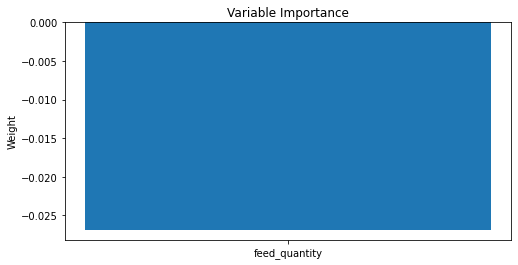

In [30]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1), weights[:, 0])
ax.set_xticks(range(1))
ax.set_xticklabels(['feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [31]:
japonica_validation_features_X

,feed_quantity
mea_dt,
2021-07-21 00:00:00,0.0
2021-07-21 00:01:00,0.0
2021-07-21 00:02:00,0.0
2021-07-21 00:03:00,0.0
2021-07-21 00:04:00,0.0
...,...
2021-09-08 23:55:00,0.0
2021-09-08 23:56:00,0.0
2021-09-08 23:57:00,0.0


In [32]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1


In [33]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 90 nVar: 720


64800


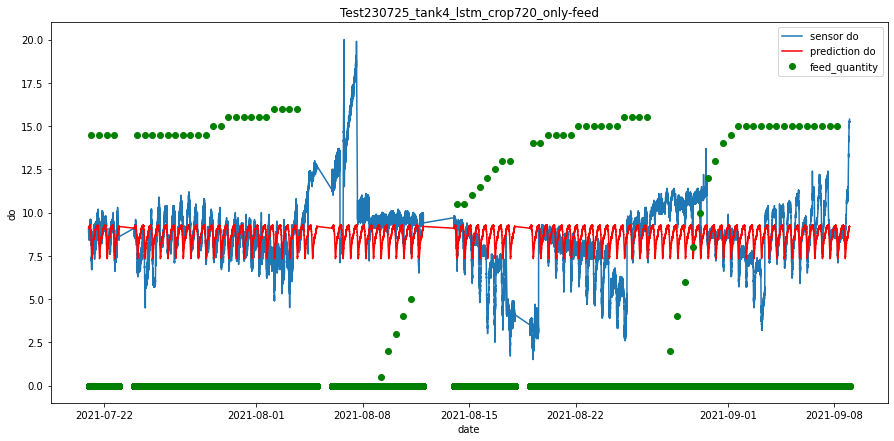

3/3 [==============================] - 1s 43ms/step - loss: 3.9245 - mae: 1.3508 - r_squared: -0.0211
MSE // MAE // R-squared  [3.924509048461914, 1.350791573524475, -0.021131157875061035]


In [34]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [35]:
X = japonica_validation_data.loc['2021-08-02 00:00':'2021-08-03 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1


In [36]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 2880 nVar: 1
nCar: 4 nVar: 720


2880


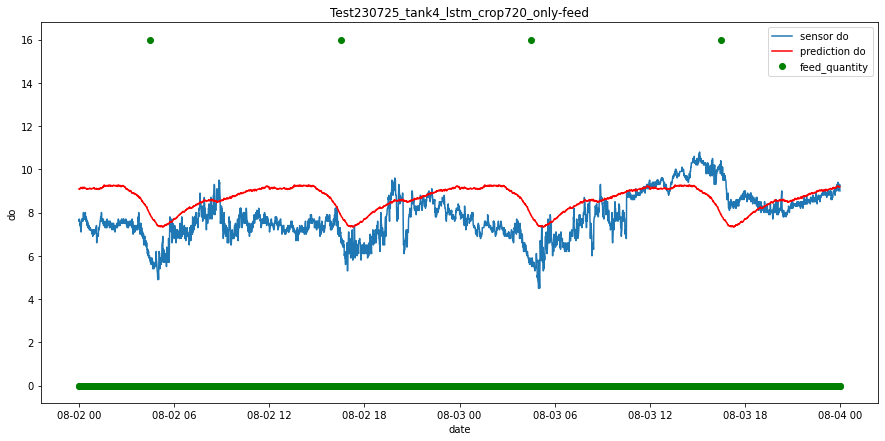

1/1 [==============================] - 0s 95ms/step - loss: 1.6398 - mae: 1.0965 - r_squared: -0.4604
MSE // MAE // R-squared  [1.6398371458053589, 1.0964608192443848, -0.46036088466644287]


In [37]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [38]:
X = japonica_validation_data.loc['2021-08-01 00:00':'2021-08-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14 nVar: 1


In [39]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 10080 nVar: 1
nCar: 14 nVar: 720


10080


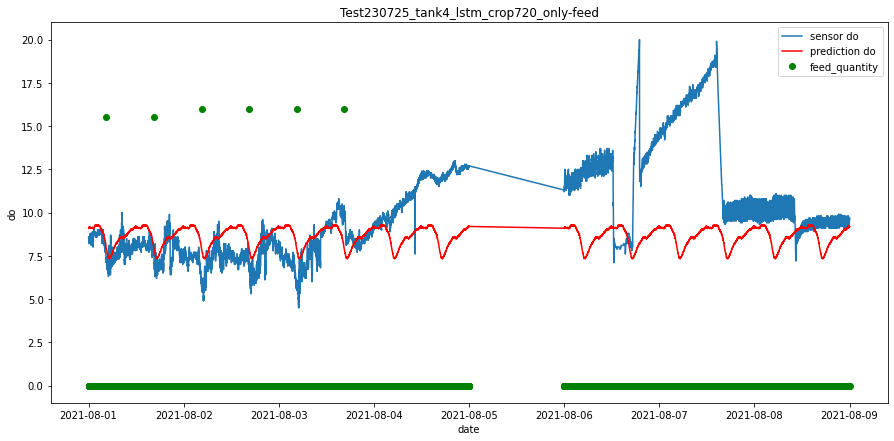

1/1 [==============================] - 0s 105ms/step - loss: 10.5940 - mae: 2.3045 - r_squared: -0.2756
MSE // MAE // R-squared  [10.59399700164795, 2.3044967651367188, -0.2756105661392212]


In [40]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [41]:
X = japonica_validation_data.loc['2021-08-03 00:00':'2021-08-03 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1 nVar: 1


In [42]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 1 nVar: 720


720


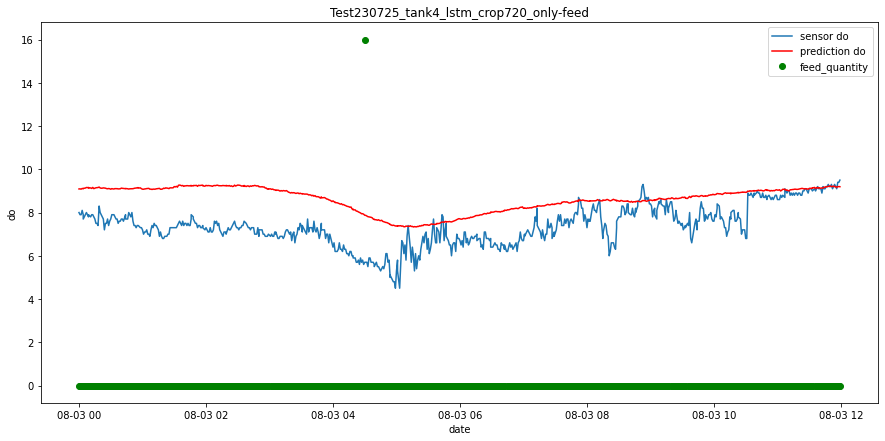

1/1 [==============================] - 0s 84ms/step - loss: 2.0820 - mae: 1.2577 - r_squared: -1.4537
MSE // MAE // R-squared  [2.0820467472076416, 1.2576711177825928, -1.4537372589111328]


In [43]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

nCar: 1 nVar: 1
nCar: 720 nVar: 1
nCar: 1 nVar: 720
720


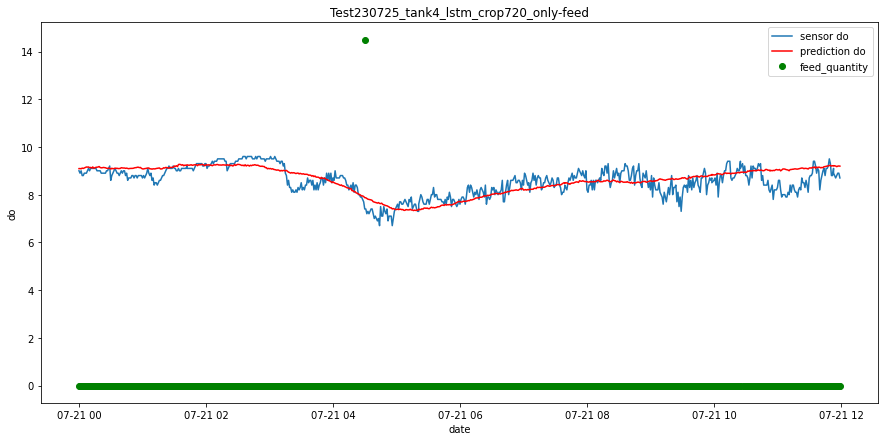

1/1 [==============================] - 0s 72ms/step - loss: 0.1598 - mae: 0.3195 - r_squared: 0.5495
MSE // MAE // R-squared  [0.15976865589618683, 0.3194838762283325, 0.5495126247406006]


In [44]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)